In [20]:
import torch
import os
from torch import optim
from tqdm.auto import trange, tqdm
try:
    from torchmetrics import Accuracy
except ImportError:
    !pip install -q torchmetrics
if torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = torch.cuda.device_count() // 2
    num_cores = torch.cuda.device_count()
else:
    device = torch.device("cpu")
    num_workers = os.cpu_count() // 2
    num_cores = os.cpu_count()
print(f"num workers : {num_workers}\ndevice : {device}\nnum cores : {num_cores}")

num workers : 0
device : cuda
num cores : 1


In [21]:
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Subset, random_split, TensorDataset
import random
# Load Fashion-MNIST

transform = v2.Compose([
    # v2.AutoAugment(),
    # v2.GaussianBlur((3, 3)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))]
)
Data_set = datasets.FashionMNIST(
root='./data', train=True, download=True, transform=transform)

# Make a class imbalanced (reduce to 20%)
def unbalance_dataset(dataset, target_class=5, reduction_ratio=0.2):
    indices = list(range(len(dataset)))
    targets = dataset.targets
    class_indices = [i for i in indices if targets[i] == target_class]
    other_indices = [i for i in indices if targets[i] != target_class]
    reduced_class_indices = random.sample(
    class_indices, int(len(class_indices) * reduction_ratio)
    )
    new_indices = other_indices + reduced_class_indices
    random.shuffle(new_indices)
    return Subset(dataset, new_indices)
imbalanced_data = unbalance_dataset(Data_set, target_class=5, reduction_ratio = 0.2)
train_size = int(len(imbalanced_data) * 0.95)
val_size = len(imbalanced_data) - train_size
train_data, val_data = random_split(imbalanced_data, [train_size, val_size])
batch_size = 32
if num_workers > 0:
    pers_workers = True
else:
    pers_workers=False
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers, pin_memory=True)

In [22]:
#experimenting on data
next(iter(train_loader))[0].shape

torch.Size([32, 1, 28, 28])

In [23]:
from torch import nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(self._make_layers(input_channel=1, output_channel=64))
        number_of_layers = 10
        for layer in range(number_of_layers):
            self.layers.append(self._make_layers())
            if layer != 0 and layer % 5 == 0:
                self.layers.append(nn.AvgPool2d(kernel_size=2, stride=2, padding=1))
        with torch.inference_mode():
            dummy_input = torch.zeros(1, 1, 28, 28)
            conv = nn.Sequential(*self.layers)
            out_conv = conv(dummy_input)
            out_dim = out_conv.numel()

        self.FC = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
    def _make_layers(self, input_channel=64, output_channel=64, kernel_size=3, padding=1):
        one_layer = nn.Sequential(nn.Conv2d(input_channel, output_channel,kernel_size,padding=padding),
                    nn.BatchNorm2d(output_channel),
                    nn.GELU(),
                    nn.Dropout2d(0.05))
        return one_layer

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return self.FC(x)


In [24]:
class ResidualNetwork(nn.Module):
    def __init__(self, depth=20, res_each=4):
        super().__init__()
        self.res_each = res_each
        self.module = nn.ModuleList()
        self.module.append(self._make_layer(1, 32))
        for i in range(depth - 1,):
            self.module.append(self._make_layer(32, 32))
        with torch.inference_mode():
            seq = nn.Sequential(*self.module)
            dummy_input = torch.zeros(1, 1, 28, 28)
            out_seq = seq(dummy_input)
            C, H, W = out_seq.shape[1:]
            out_dim = C * H * W
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
    def _make_layer(self, in_channel, out_channel, stride=1, pad=1, kernel=3, batch_norm=True, activation= nn.GELU, dropout_rate=0.5):
        self.stride = stride
        seq = nn.Sequential(
                nn.Conv2d(in_channels=in_channel,
                out_channels=out_channel,
                kernel_size=kernel,
                padding=pad),
                nn.BatchNorm2d(out_channel) if batch_norm else nn.Identity(),
                activation(),
                nn.Dropout(dropout_rate)
)
        return seq
    def forward(self, x):
        res = x
        for i, layer in enumerate(self.module):
            x = layer(x)
            if i % self.res_each == 0:
                x += res
                res = x
        return self.classifier(x)

In [34]:

epochs = 20
avg_train_loss = []
avg_val_loss = []

# torch.set_float32_matmul_precision("high")
model = ResidualNetwork().to(device)
model = torch.compile(model, fullgraph = True)

criterion = nn.CrossEntropyLoss()
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3)

# scaler = torch.amp.GradScaler(device.type)
train_accuracy = Accuracy("multiclass", num_classes=10).to(device)
val_accuracy = Accuracy("multiclass", num_classes=10).to(device)
history = {
    "train loss" : [],
    "val loss" : [],
    "train accuracy" : [],
    "val accuracy" : []
}

for epoch in trange(1, epochs+1):
    model.train()
    running_train_loss = 0.0
    running_val_loss = 0.0
    train_accuracy.reset()

    for x_train, y_train in tqdm(train_loader, leave=False):
        x_train, y_train = x_train.to(device, non_blocking=True), y_train.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        # with torch.amp.autocast(device.type):
        train_preds = model(x_train)
        train_loss = criterion(train_preds, y_train)
        # scaler.scale(train_loss).backward()
        # scaler.unscale_(opt)
        # scaler.step(opt)
        # scaler.update()
        train_loss.backward()
        opt.step()
        running_train_loss += train_loss.item()
        train_accuracy.update(train_preds, y_train)
    model.eval()
    with torch.inference_mode():
        for x_val, y_val in tqdm(val_loader, leave=False):
            x_val, y_val = x_val.to(device, non_blocking=True), y_val.to(device, non_blocking=True)
            # with torch.amp.autocast(device.type):
            val_preds = model(x_val)
            val_loss = criterion(val_preds, y_val)
            running_val_loss += val_loss.item()
            val_accuracy(val_preds, y_val)
    avg_train = running_train_loss / len(train_loader)
    avg_val = running_val_loss / len(val_loader)
    history["train loss"].append(avg_train)
    history["val loss"].append(avg_val)
    history["train accuracy"].append(train_accuracy.compute().item())
    history["val accuracy"].append(val_accuracy.compute().item())

    scheduler.step(avg_val)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

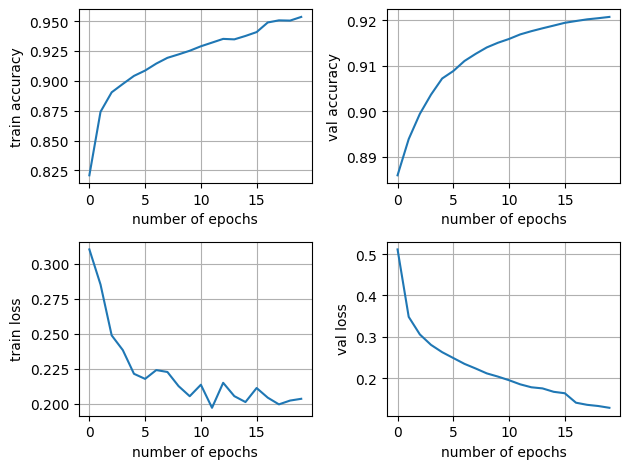

In [35]:
import matplotlib.pyplot as plt
def plot(list_of_losses: list, name_of_loss: str, grid: tuple, num_loss):
    plt.subplot(*grid, num_loss, )
    plt.plot(range(len(list_of_losses)), list_of_losses)
    plt.xlabel("number of epochs")
    plt.ylabel(name_of_loss)
    plt.grid(True)
    plt.tight_layout()
plot(history['train accuracy'], "train accuracy", (2, 2), 1)
plot(history["val accuracy"], "val accuracy", (2, 2), 2)
plot(history['val loss'], "train loss", (2, 2), 3)
plot(history["train loss"], "val loss", (2, 2), 4)

In [36]:
test_data = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

In [28]:
history

{'train loss': [0.5157336321834968,
  0.34821683629810846,
  0.308720977018889,
  0.28778561103754907,
  0.26387643756355145],
 'val loss': [0.33473210259415637,
  0.29740383891367367,
  0.2578064339428112,
  0.24330987190378123,
  0.21981604876874508],
 'train accuracy': [0.8184210658073425,
  0.8751335144042969,
  0.8887872099876404,
  0.8961479663848877,
  0.9048054814338684],
 'val accuracy': [0.8764492869377136,
  0.883152186870575,
  0.8899758458137512,
  0.8954710364341736,
  0.9008695483207703]}

In [37]:
from sklearn.metrics import accuracy_score, f1_score
test_preds = []
test_true = []
test_loader = DataLoader(test_data, batch_size = 1024)
model.eval()
with torch.inference_mode():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        predicts = model(x_test).argmax(dim=1).cpu().numpy()
        test_preds.extend(predicts)
        test_true.extend(y_test)
accuracy_score(test_true, test_preds), f1_score(test_true, test_preds, average="macro")

(0.9327, 0.9321763500626753)

In [30]:
#accuracy and f1-score baseline model (0.8945, 0.8940189202461971) on Fashion mnist
#val loss 0.26607947051525116
#accuracy and f1-score deep cnn model (0.8823, 0.8812410909538319) on Fashion mnist
#val loss 0.28135160121253167
#accuracy and f1-score deep cnn model without max pool(0.9105, 0.9104130708612793) on Fashion mnist / deeper one (0.9293, 0.9290120605469332)
#val loss  0.2229161468045465
#
#



